<a href="https://colab.research.google.com/github/ChristianParsons98/PG_Lab_Code/blob/main/LLTO_R_Raman_FullFit_V4_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install lmfit

In [25]:
%matplotlib inline
from sympy import init_printing
init_printing(use_latex=True)
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import pandas as pd
import math
import scipy
from scipy.stats import chisquare
print(scipy.__version__)
from scipy.optimize import leastsq
from scipy.special import voigt_profile
from sklearn.metrics import r2_score
import csv
from scipy.signal import find_peaks
import lmfit
from lmfit.models import VoigtModel, LinearModel, GaussianModel, LorentzianModel

#This document is used to fit the raman data to Lorentzians
#For LLYTO made with Rutile

#Uses file /content/LLTO_W_1.PRN


1.16.1


In [26]:
#Importing the Results for LLTO and LLYTO

def Load_Raman_Data(file_path):
    #Function to load tab-delimited .PRN Raman data from Renishaw
    df = pd.read_csv(file_path, delimiter='\t', header=None, names=['wavenumber', 'intensity'])
    return df


#Load the file file
dfA2 = Load_Raman_Data('/content/LLTO_W_1.PRN')

wna2 = dfA2['wavenumber'].to_numpy()
wna2 = wna2[:-1].astype(float)
intensitya2 = dfA2['intensity'].to_numpy()[:-1]

In [27]:
#Helper function to find peak indicies.
peaks, _ = find_peaks(intensitya2, prominence=1000)
#peaks = find_peaks(intensitya2, prominence=1000)
for peak in peaks:
  print(wna2[peak])

138.79
237.25
312.66
457.21
524.24
773.53


In [28]:
#If the peak is not showing up above this may help.

#helper function to find index closest to my guess angle
def closest(lst, K):
    val=lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    return lst.index(val)

#helper function to find index of nearest peak given a guess index
def peakfind(lst,K):
    temp=lst[K-15:K+15]
    maxval=max(temp)
    mindx=temp.index(maxval)
    #index = lst.index(maxval)
    index=K-15+mindx
    return index

In [29]:
#Example of using the above helper functions to find the index for a specific wavenumber
templst=wna2.tolist()
print(closest(templst,100))

48


In [30]:
#This function fits a voigt function for a given index
#x is the list form of wavenumber (nparray), y is the list form of Int (nparray)
#Takes the index of the peak center, and number of points to the left and right of the center
# that should be considered in the fit.
def VPeakFit(WN,Int,icenter,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki= icenter
    pkang= WN[pki]
    tempx=WN[pki-nleft:pki+nright]
    tempy=Int[pki-nleft:pki+nright]

    #Fitting
    #Define the model for a single peak
    model = VoigtModel(prefix='p0_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang, min=pkang-20, max=pkang+20)
    params.add(f'p0_sigma', value=20, min=0.01)
    params.add(f'p0_gamma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)

    result = model.fit(tempy, params, x=tempx)
    result.plot()
    print(result.fit_report())

In [31]:
#This function fits a Lorentzian function for a given index
#x is the list form of wavenumber (nparray), y is the list form of Int (nparray)
#Takes the index of the peak center, and number of points to the left and right of the center
# that should be considered in the fit.
def LPeakFit(WN,Int,icenter,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki= icenter
    pkang= WN[pki]
    tempx=WN[pki-nleft:pki+nright]
    tempy=Int[pki-nleft:pki+nright]

    #Fitting
    #Define the model for a single peak
    model = LorentzianModel(prefix='p0_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang, min=pkang-20, max=pkang+20)
    params.add(f'p0_sigma', value=20, min=0.01)
    #params.add(f'p0_gamma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)

    result = model.fit(tempy, params, x=tempx)
    #result.plot()
    #print(result.fit_report())
    return result

In [32]:
#Same as above but for jointly fitting the two peaks that should be around 500
# One at ~525 and the other at ~580
# icenters is a list of two peak center indicies - lower index first.
def L2PeakFit(WN,Int,icenters,nleft,nright):
    x=WN.tolist()
    y=Int.tolist()
    pki1= icenters[0]
    pkang1= WN[pki1]
    pki2= icenters[1]
    pkang2= WN[pki2]
    tempx=WN[pki1-nleft:pki2+nright]
    tempy=Int[pki1-nleft:pki2+nright]

    #Fitting
    #Define the model for a single peak
    model = LorentzianModel(prefix='p0_')
    model += LorentzianModel(prefix='p1_')
    #Instantiate the Parameters() object for lmfit
    params = lmfit.Parameters()

    params.add(f'p0_center', value=pkang1, min=pkang1-10, max=pkang1+10)
    params.add(f'p0_sigma', value=20, min=0.01)
    params.add(f'p0_amplitude', value=1000000, min=0)
    params.add(f'p1_center', value=pkang2, min=pkang2-20, max=pkang2+20)
    params.add(f'p1_sigma', value=20, min=0.01)
    params.add(f'p1_amplitude', value=1000000, min=0)


    result = model.fit(tempy, params, x=tempx)
    return result

In [33]:
#Now we go through and fit each peak individually...

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 20
    # variables        = 3
    chi-square         = 68158009.6
    reduced chi-square = 4009294.68
    Akaike info crit   = 306.832139
    Bayesian info crit = 309.819336
    R-squared          = 0.99453655
[[Variables]]
    p0_center:     139.630114 +/- 0.06083048 (0.04%) (init = 138.79)
    p0_sigma:      19.8633823 +/- 0.22038364 (1.11%) (init = 20)
    p0_amplitude:  21450089.8 +/- 207969.522 (0.97%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9890
    C(p0_center, p0_amplitude) = +0.3557
    C(p0_center, p0_sigma)     = +0.3379


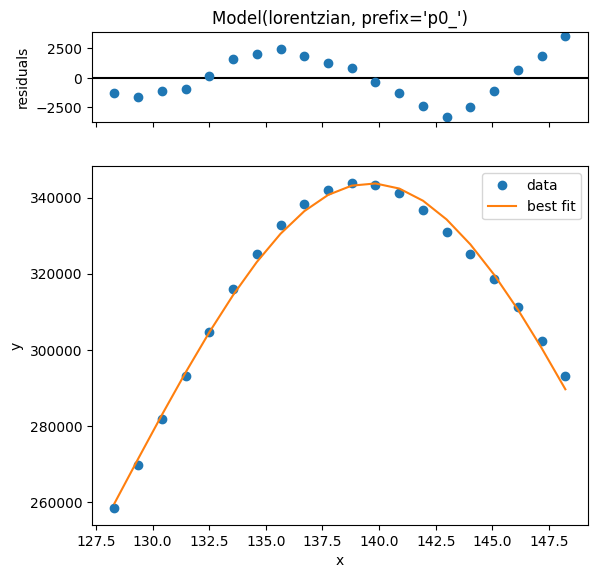

In [34]:
Peak1 = LPeakFit(wna2, intensitya2,peaks[0],10,10)
Peak1.plot()
print(Peak1.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 20
    # variables        = 3
    chi-square         = 2039125.48
    reduced chi-square = 119948.558
    Akaike info crit   = 236.645986
    Bayesian info crit = 239.633183
    R-squared          = 0.98722658
[[Variables]]
    p0_center:     235.966441 +/- 0.08099345 (0.03%) (init = 237.25)
    p0_sigma:      45.8203651 +/- 0.67228662 (1.47%) (init = 20)
    p0_amplitude:  26309291.9 +/- 373701.111 (1.42%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9995
    C(p0_center, p0_amplitude) = -0.2584
    C(p0_center, p0_sigma)     = -0.2551


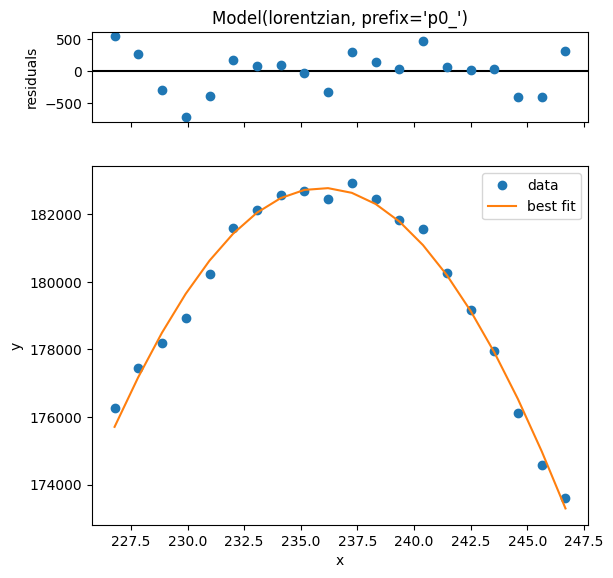

In [35]:
Peak2 = LPeakFit(wna2, intensitya2,peaks[1],10,10)
Peak2.plot()
print(Peak2.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 42
    # data points      = 20
    # variables        = 3
    chi-square         = 4158175.95
    reduced chi-square = 244598.585
    Akaike info crit   = 250.897096
    Bayesian info crit = 253.884293
    R-squared          = 0.93954085
[[Variables]]
    p0_center:     311.803035 +/- 0.17068254 (0.05%) (init = 312.66)
    p0_sigma:      46.9134812 +/- 1.49027243 (3.18%) (init = 20)
    p0_amplitude:  18567115.5 +/- 571592.810 (3.08%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9996
    C(p0_center, p0_amplitude) = -0.1183
    C(p0_center, p0_sigma)     = -0.1168


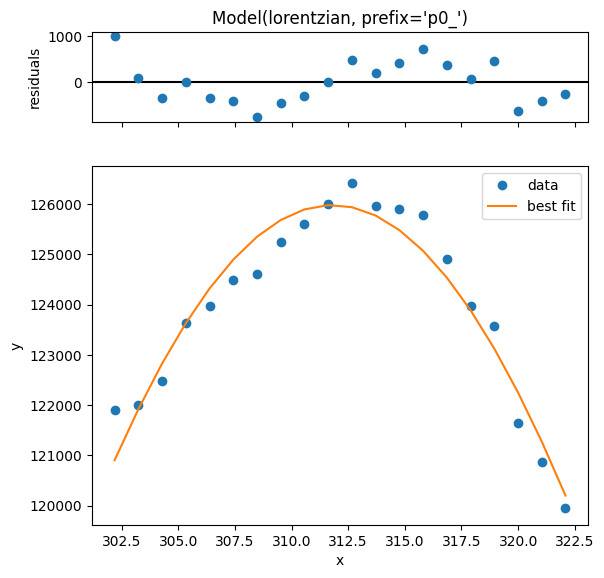

In [36]:
Peak3 = LPeakFit(wna2, intensitya2,peaks[2],10,10)
Peak3.plot()
print(Peak3.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 20
    # variables        = 3
    chi-square         = 2298203.04
    reduced chi-square = 135188.414
    Akaike info crit   = 239.038116
    Bayesian info crit = 242.025313
    R-squared          = 0.95458132
[[Variables]]
    p0_center:     457.467434 +/- 0.15664638 (0.03%) (init = 457.21)
    p0_sigma:      34.1738513 +/- 0.97755477 (2.86%) (init = 20)
    p0_amplitude:  6265803.19 +/- 169500.807 (2.71%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9985
    C(p0_center, p0_amplitude) = +0.2544
    C(p0_center, p0_sigma)     = +0.2489


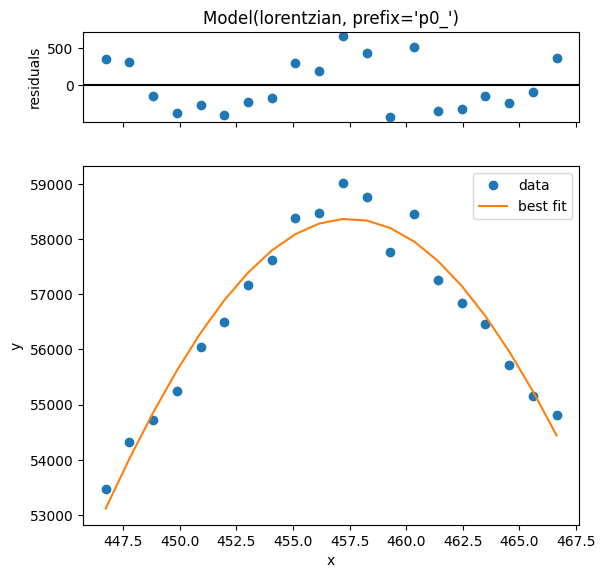

In [37]:
Peak4 = LPeakFit(wna2, intensitya2,peaks[3],10,10)
Peak4.plot()
print(Peak4.fit_report())

[[Model]]
    (Model(lorentzian, prefix='p0_') + Model(lorentzian, prefix='p1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 146
    # data points      = 81
    # variables        = 6
    chi-square         = 8518499.05
    reduced chi-square = 113579.987
    Akaike info crit   = 948.627426
    Bayesian info crit = 962.994121
    R-squared          = 0.99966480
[[Variables]]
    p0_center:     521.849013 +/- 0.08431444 (0.02%) (init = 526.34)
    p0_sigma:      27.0408173 +/- 0.67381343 (2.49%) (init = 20)
    p0_amplitude:  5638332.26 +/- 376044.985 (6.67%) (init = 1000000)
    p1_center:     559.760000 +/- 1.86652971 (0.33%) (init = 579.76)
    p1_sigma:      60.7091472 +/- 1.45214051 (2.39%) (init = 20)
    p1_amplitude:  11904995.9 +/- 603870.397 (5.07%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p1_center, p1_amplitude)    = -0.9943
    C(p0_amplitude, p1_center)    = +0.9926
    C(p0_amplitude, p1_amplitude) = -

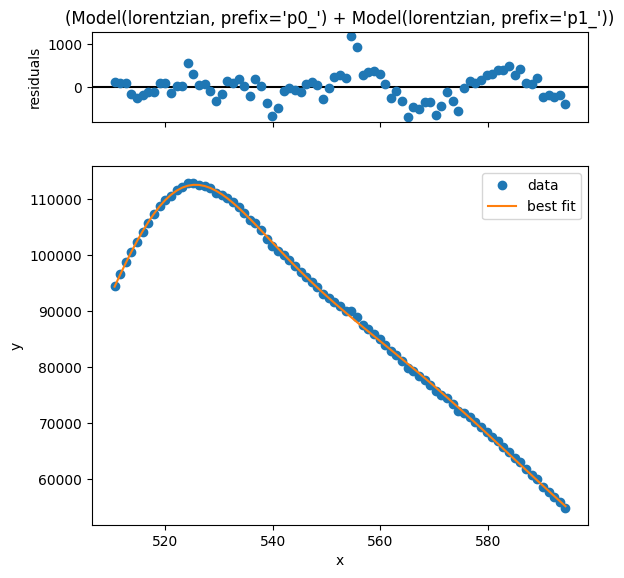

In [38]:
#The peaks at 525 and 580 near the indices 455 and 506.
Peaks5_6 = L2PeakFit(wna2, intensitya2,[455,506],15,15)
Peaks5_6.plot()
print(Peaks5_6.fit_report())

[[Model]]
    Model(lorentzian, prefix='p0_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 80
    # variables        = 3
    chi-square         = 2859491.01
    reduced chi-square = 37136.2469
    Akaike info crit   = 844.730205
    Bayesian info crit = 851.876285
    R-squared          = 0.83005294
[[Variables]]
    p0_center:     775.966692 +/- 0.60619709 (0.08%) (init = 773.53)
    p0_sigma:      209.646217 +/- 5.72548429 (2.73%) (init = 20)
    p0_amplitude:  23043210.7 +/- 613676.704 (2.66%) (init = 1000000)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0_sigma, p0_amplitude)  = +0.9997
    C(p0_center, p0_amplitude) = +0.2538
    C(p0_center, p0_sigma)     = +0.2513


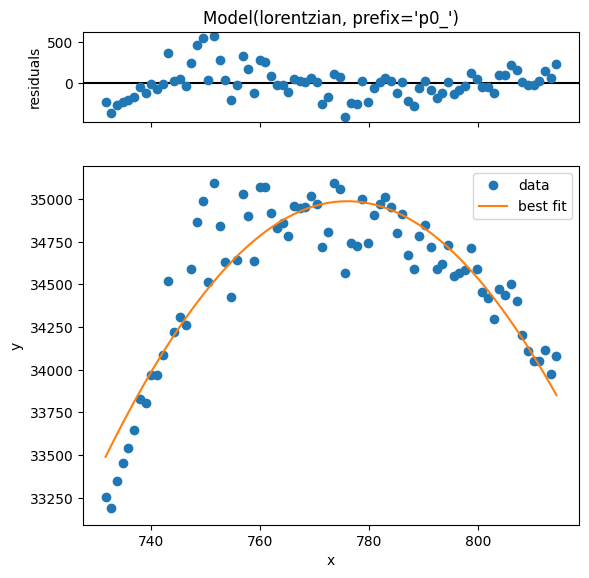

In [39]:
Peak7 = LPeakFit(wna2, intensitya2,peaks[5],40,40)
Peak7.plot()
print(Peak7.fit_report())

In [40]:
def lorentzian(x, x0, sigma, amplitude):
        return amplitude/np.pi * (sigma / ((x - x0)**2 + sigma**2))

In [41]:
#But the amplitude is not exactly correct when we jointly fit. Peak center should be ok.

In [42]:
#Let's make a list of values
pvlst=[]

#peaks 1-4
PL = [Peak1, Peak2, Peak3, Peak4]
for peak in PL:
    tdl = list(peak.params.valuesdict().values())
    pvlst.append(tdl)
#peaks 5-6
pvlst.append(list(Peaks5_6.params.valuesdict().values())[:3])
pvlst.append(list(Peaks5_6.params.valuesdict().values())[3:])
#peak 7
pvlst.append(list(Peak7.params.valuesdict().values()))

print(pvlst)

[[139.6301139423102, 19.863382278390112, 21450089.768154517], [235.9664410126867, 45.82036508189422, 26309291.91212233], [311.8030351915922, 46.91348115547066, 18567115.526895575], [457.46743385455625, 34.17385127710476, 6265803.185321755], [521.8490132637587, 27.04081733451518, 5638332.25977629], [559.7600000250128, 60.709147188966526, 11904995.939637791], [775.9666919825327, 209.6462165509942, 23043210.709840313]]


[[Model]]
    ((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4041
    # data points      = 833
    # variables        = 14
    chi-square         = 2.4275e+10
    reduced chi-square = 29639529.5
    Akaike info crit   = 14345.3290
    Bayesian info crit = 14411.4795
    R-squared          = 0.99314406
##  Warning: uncertainties could not be estimated:
    p1_sigma:      at boundary
    p3_sigma:      at boundary
    p4_sigma:      at boundary
    p4_amplitude:  at boundary
    p5_sigma:      at boundary
    p6_sigma:      at boundary
    p7_sigma:      at boundary
[[Variables]]
    p1_center:     139.6301 (fixed)
    p1_sigma:      23.8360587 (init = 19.86338)
    p1_amplitude:  21791480.8 (init = 2.145009e+07)
 

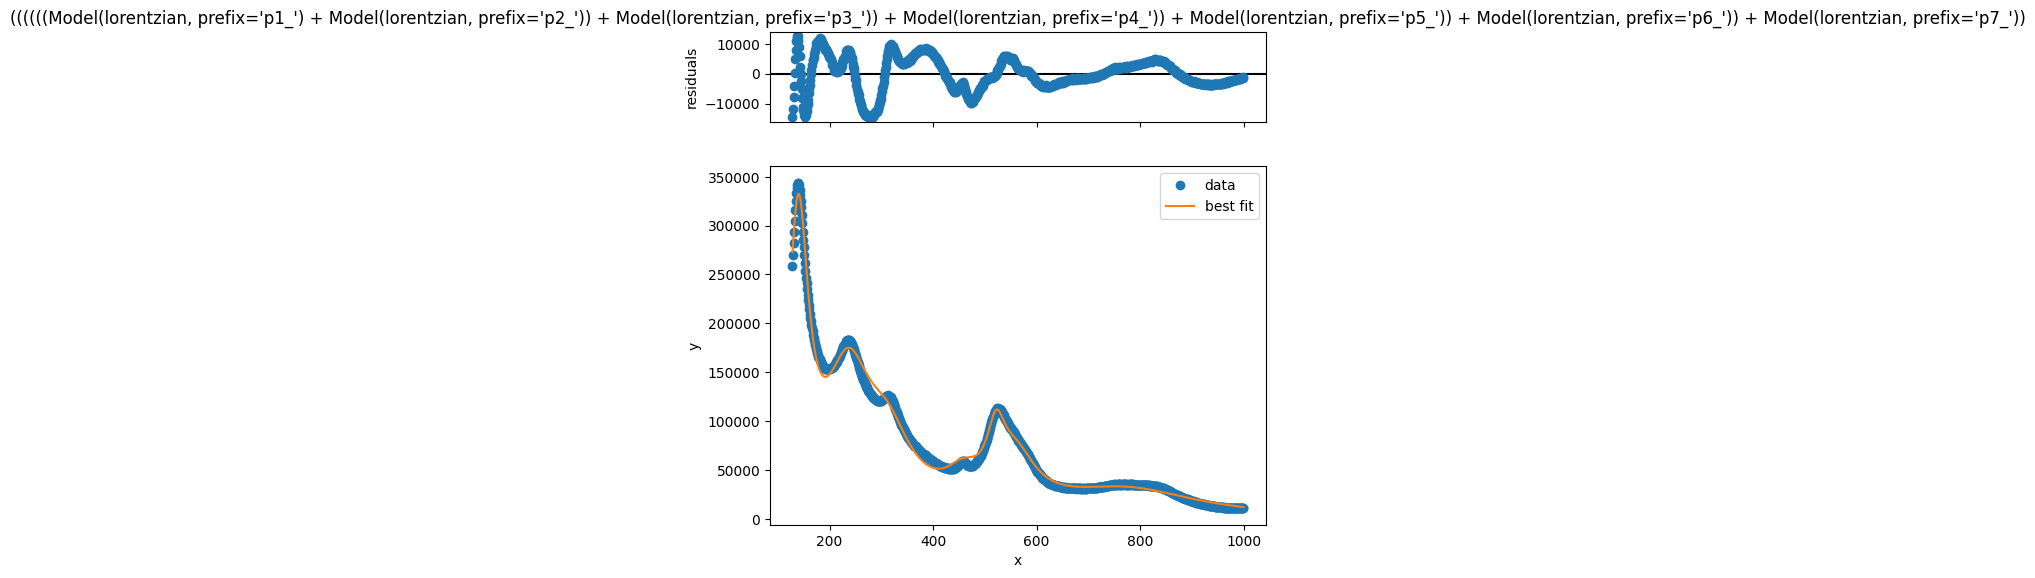

In [43]:
#We will see that we cannot fully fit the spectrum with the expected 7 peaks.
#There is a small piece missing around 390 cm-1...
#This first one is the required
model = LorentzianModel(prefix='p1_')
for i in range(2, 8):
    model += LorentzianModel(prefix=f'p{i}_')
#Instantiate the Parameters() object for lmfit
params = lmfit.Parameters()
for i in range(1,8):
    params.add(f'p{i}_center', value=pvlst[i-1][0], vary=False)
    params.add(f'p{i}_sigma', value=pvlst[i-1][1], min=pvlst[i-1][1]*0.8, max=pvlst[i-1][1]*1.2)
    params.add(f'p{i}_amplitude', value=pvlst[i-1][2], min=pvlst[i-1][2]*0.5, max=pvlst[i-1][2]*1.5)

result = model.fit(intensitya2[75:], params, x=wna2[75:])
result.plot()
print(result.fit_report())

[[Model]]
    (((((((Model(lorentzian, prefix='p1_') + Model(lorentzian, prefix='p2_')) + Model(lorentzian, prefix='p3_')) + Model(lorentzian, prefix='p4_')) + Model(lorentzian, prefix='p5_')) + Model(lorentzian, prefix='p6_')) + Model(lorentzian, prefix='p7_')) + Model(lorentzian, prefix='p8_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1544
    # data points      = 833
    # variables        = 17
    chi-square         = 8.4057e+09
    reduced chi-square = 10301046.9
    Akaike info crit   = 13467.9050
    Bayesian info crit = 13548.2305
    R-squared          = 0.99762598
[[Variables]]
    p1_center:     139.6301 (fixed)
    p1_sigma:      24.4614827 +/- 0.23742143 (0.97%) (init = 19.86338)
    p1_amplitude:  22286002.2 +/- 246043.461 (1.10%) (init = 2.145009e+07)
    p2_center:     235.9664 (fixed)
    p2_sigma:      53.3582796 +/- 0.89428868 (1.68%) (init = 45.82037)
    p2_amplitude:  24345774.2 +/- 482084.401 (1.98%) (init = 2.630929e+07)
    p

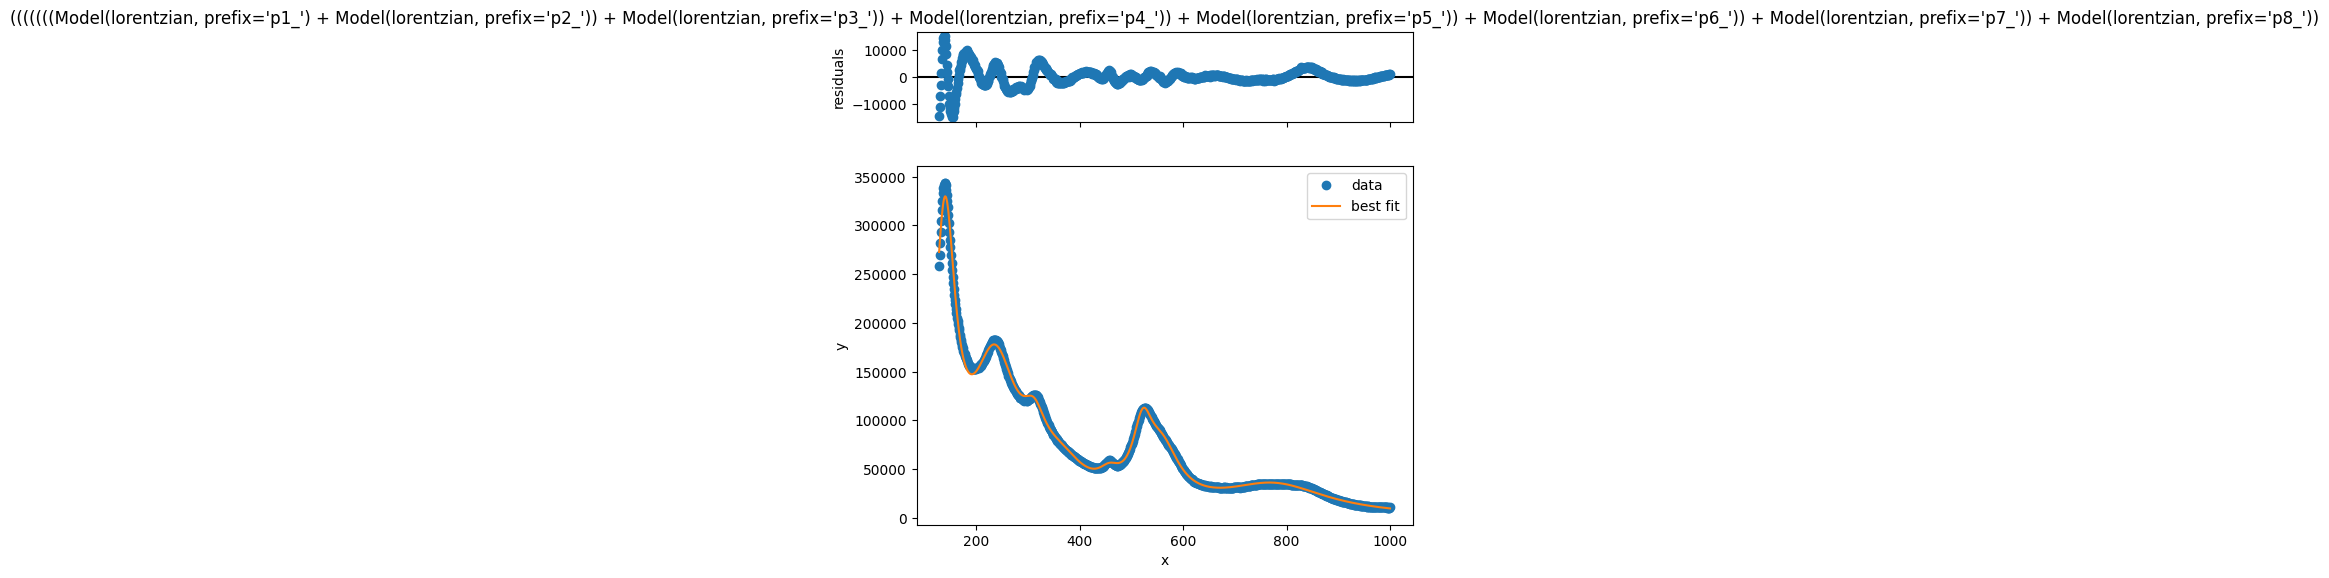

In [44]:
#As above but adding an additional peak around 390
#This first one is the required
model = LorentzianModel(prefix='p1_')
for i in range(2, 9):
    model += LorentzianModel(prefix=f'p{i}_')
#Instantiate the Parameters() object for lmfit
params = lmfit.Parameters()
for i in range(1,8):
    params.add(f'p{i}_center', value=pvlst[i-1][0], vary=False)
    params.add(f'p{i}_sigma', value=pvlst[i-1][1], min=pvlst[i-1][1]*0.6, max=pvlst[i-1][1]*1.3)
    params.add(f'p{i}_amplitude', value=pvlst[i-1][2], min=pvlst[i-1][2]*0.2, max=pvlst[i-1][2]*1.9)

#There seems to be something going on around ~390 that needs to be accounted for...
params.add(f'p8_center', value=390, min=360, max=420)
params.add(f'p8_sigma', value=20, min=0.01)
params.add(f'p8_amplitude', value=1000000, min=0)


result = model.fit(intensitya2[75:], params, x=wna2[75:])
result.plot()
print(result.fit_report())

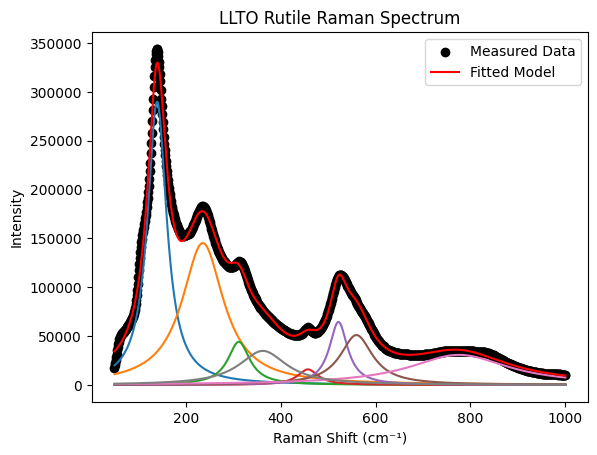

In [45]:
#Make a nice plot

ysim=np.zeros(1000)
xsim=np.linspace(50,1000,1000)

rdict = result.params.valuesdict()

plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity")
plt.title("LLTO Rutile Raman Spectrum")
plt.scatter(wna2,intensitya2, c='k', label='Measured Data')
for i in range(1,9):
  y= lorentzian(xsim, rdict[f'p{i}_center'], rdict[f'p{i}_sigma'], rdict[f'p{i}_amplitude'])
  ysim+=y
  plt.plot(xsim,y)
plt.plot(xsim,ysim,'r', label='Fitted Model')
plt.legend()
plt.savefig('LLTO_Rutile_Raman_FullFit.png',dpi=600)
plt.show()

In [46]:
print('LLTO_Anatase_Params')
result.params.valuesdict()

LLTO_Anatase_Params


{'p1_center': 139.6301139423102,
 'p1_sigma': 24.46148273994416,
 'p1_amplitude': 22286002.239339657,
 'p2_center': 235.9664410126867,
 'p2_sigma': 53.358279550172554,
 'p2_amplitude': 24345774.23870371,
 'p3_center': 311.8030351915922,
 'p3_sigma': 28.148088694290607,
 'p3_amplitude': 3901113.9447702826,
 'p4_center': 457.46743385455625,
 'p4_sigma': 26.487200069220712,
 'p4_amplitude': 1327588.1102115542,
 'p5_center': 521.8490132637587,
 'p5_sigma': 23.357063711102214,
 'p5_amplitude': 4732733.2748085,
 'p6_center': 559.7600000250128,
 'p6_sigma': 41.54570712941682,
 'p6_amplitude': 6665901.439948183,
 'p7_center': 775.9666919825327,
 'p7_sigma': 128.17236983128777,
 'p7_amplitude': 12401837.808632478,
 'p8_center': 362.5919882082717,
 'p8_sigma': 61.00063368153816,
 'p8_amplitude': 6681854.780744435}